In [10]:
import geopandas as gpd
import json
import ast
import os
from large_image import getTileSource
from typing import Callable

In [11]:
SAVE_DIR = "../../data/processed/yolo"
DATA_DIR = "../../data/raw/slides/"

In [12]:
WSI_PATH = os.path.join(DATA_DIR, "slide-2024-04-03T07-52-35-R1-S2.mrxs")
DEFAULT_W, DEFAULT_H = 8000, 8000

source = getTileSource(WSI_PATH)

metadata = source.getMetadata()
mpp_x = float(metadata.get("mm_x", 0)) * 1000  # convert mm to microns
mpp_y = float(metadata.get("mm_y", 0)) * 1000

print(f"WSI Resolution: {mpp_x} × {mpp_y} microns per pixel")

WSI_WIDTH = metadata.get("sizeX", DEFAULT_W) # default width
WSI_HEIGHT = metadata.get("sizeY", DEFAULT_H) # default height

WSI Resolution: 0.274358240290104 × 0.274358240290104 microns per pixel


In [68]:
DEFAULT_MARGIN = 20

# width, height => margin
MarginFn = Callable[[int, int], int]

annotations = gpd.read_file(os.path.join(DATA_DIR, "slide-2024-04-03T07-52-35-R1-S2.geojson"))

def polygon_to_yolo_bbox(geom, img_width, img_height, margin_fn:MarginFn = lambda widht, height: DEFAULT_MARGIN):
    minx, miny, maxx, maxy = geom.bounds

    margin = margin_fn(maxx-minx, maxy-miny)

    minx -= margin
    miny -= margin
    maxx += margin
    maxy += margin
    
    # clip to image size (avoid negatives / overflow)
    minx = max(0, minx)
    miny = max(0, miny)
    maxx = min(img_width, maxx)
    maxy = min(img_height, maxy)

    # YOLO format: (x_center, y_center, w, h), normalized [0,1]
    # x_center = (minx + maxx) / 2 / img_width
    # y_center = (miny + maxy) / 2 / img_height
    # w = (maxx - minx) / img_width
    # h = (maxy - miny) / img_height

    x_center = (minx + maxx) / 2
    y_center = (miny + maxy) / 2
    w = (maxx - minx)
    h = (maxy - miny)

    return {
        "normalized": (x_center / img_width, y_center / img_height, w / img_width, h / img_height),
        "expanded": (x_center, y_center, w, h),
    }



In [69]:
# extract unique class names
annotations["class_name"] = annotations["classification"].apply(lambda x: ast.literal_eval(x)["name"])
class_mapping = {name: i for i, name in enumerate(annotations["class_name"].unique())}
print(class_mapping)

{'veľké nepravidelné jadro': 0, 'veľké jadro': 1, 'nepravidelné jadro': 2, 'viacpočetné jadierka': 3, 'veľké jadierko': 4, 'mitóza': 5, 'hyperchrómne jadro': 6, 'referenčné bunky - erytrocyt': 7, 'referenčná bunky - lymfocyt': 8, 'viacjadrová bunka': 9}


# Default margin (20 px)

In [ ]:
from shapely.geometry import box

labels = []
features = []

for _, row in annotations.iterrows():
    cls = class_mapping[row["class_name"]]
    bbox = polygon_to_yolo_bbox(row["geometry"], WSI_WIDTH, WSI_HEIGHT)
    x_norm, y_norm, w_norm, h_norm = bbox["normalized"]
    labels.append(f"{cls} {x_norm:.6f} {y_norm:.6f} {w_norm:.6f} {h_norm:.6f}")

    x, y, w, h = bbox["expanded"]
    rect = box(x-w/2, y-h/2, x+w/2, y+h/2)
    features.append({
        "objectType": row["objectType"],
        "classification": row["classification"],
        "geometry": rect,
        "class_name": row["class_name"],
    })

# save to .txt for YOLO
with open(os.path.join(SAVE_DIR, "bboxes-hardMargin-slide-2024-04-03T07-52-35-R1-S2.txt"), "w") as f:
    f.write("\n".join(labels))

# save as .geojson for QUPATH
gdf = gpd.GeoDataFrame(features)
gdf.to_file(os.path.join(SAVE_DIR, "expanded_bboxes-hardMargin-slide-2024-04-03T07-52-35-R1-S2.geojson"), driver="GeoJSON")

/Users/simon/Documents/000_fiit/09_semester/DP/notebooks/pleomorphy-analysis/tile-and-segment-instances/.venv/lib/python3.11/site-packages/pyogrio/geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [82]:
from pprint import pp as pprint

yolo_annotations = gpd.read_file(os.path.join(SAVE_DIR, "expanded_bboxes-hardMargin-slide-2024-04-03T07-52-35-R1-S2.geojson"))
pprint(yolo_annotations.iloc[0])
print("========================================^v^v^v^======================================")
pprint(annotations.iloc[0])

objectType                                               annotation
classification    { "name": "veľké nepravidelné jadro", "color":...
class_name                                 veľké nepravidelné jadro
geometry          POLYGON ((39213 56443, 39213 56579, 39106 5657...
Name: 0, dtype: object
========================================^v^v^v^======================================
id                             e61be433-ec8b-40a6-be77-0684c3574b00
objectType                                               annotation
classification    { "name": "veľké nepravidelné jadro", "color":...
geometry          POLYGON ((39193 56511, 39192.93 56514.01, 3919...
class_name                                 veľké nepravidelné jadro
Name: 0, dtype: object


## Visualize alongside the original annotations

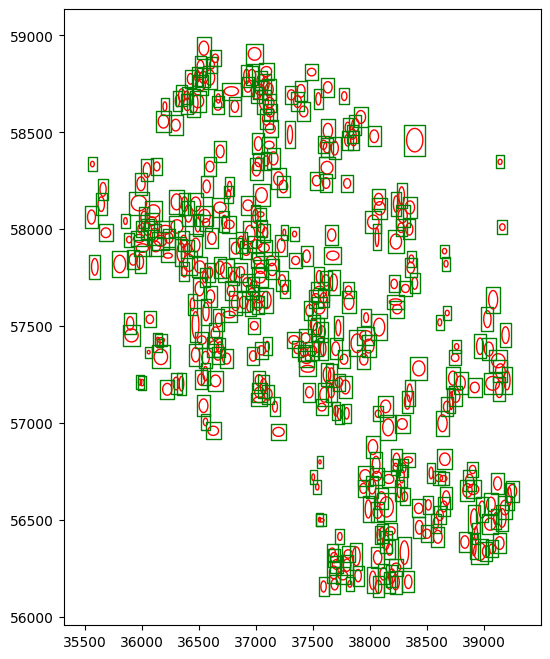

In [83]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))
annotations.plot(ax=ax, facecolor="none", edgecolor="red")
yolo_annotations.plot(ax=ax, facecolor="none", edgecolor="green")
plt.show()


# Adaptive margin

In [ ]:
labels = []
features = []

for _, row in annotations.iterrows():
    cls = class_mapping[row["class_name"]]
    bbox = polygon_to_yolo_bbox(row["geometry"], WSI_WIDTH, WSI_HEIGHT, lambda width, height: 0.1 * max(width, height))
    x_norm, y_norm, w_norm, h_norm = bbox["normalized"]
    labels.append(f"{cls} {x_norm:.6f} {y_norm:.6f} {w_norm:.6f} {h_norm:.6f}")

    x, y, w, h = bbox["expanded"]
    rect = box(x-w/2, y-h/2, x+w/2, y+h/2)
    features.append({
        "objectType": row["objectType"],
        "classification": row["classification"],
        "geometry": rect,
        "class_name": row["class_name"],
    })

# save to .txt for YOLO
with open(os.path.join(SAVE_DIR, "bboxes-adaptiveMargin-slide-2024-04-03T07-52-35-R1-S2.txt"), "w") as f:
    f.write("\n".join(labels))

# save as .geojson for QUPATH
gdf = gpd.GeoDataFrame(features)
gdf.to_file(os.path.join(SAVE_DIR, "expanded_bboxes-adaptiveMargin-slide-2024-04-03T07-52-35-R1-S2.geojson"), driver="GeoJSON")

/Users/simon/Documents/000_fiit/09_semester/DP/notebooks/pleomorphy-analysis/tile-and-segment-instances/.venv/lib/python3.11/site-packages/pyogrio/geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


# Visualize adaptive margin BBoxes

objectType                                               annotation
classification    { "name": "veľké nepravidelné jadro", "color":...
class_name                                 veľké nepravidelné jadro
geometry          POLYGON ((39202.6 56453.4, 39202.6 56568.6, 39...
Name: 0, dtype: object
========================================^v^v^v^======================================
id                             e61be433-ec8b-40a6-be77-0684c3574b00
objectType                                               annotation
classification    { "name": "veľké nepravidelné jadro", "color":...
geometry          POLYGON ((39193 56511, 39192.93 56514.01, 3919...
class_name                                 veľké nepravidelné jadro
Name: 0, dtype: object


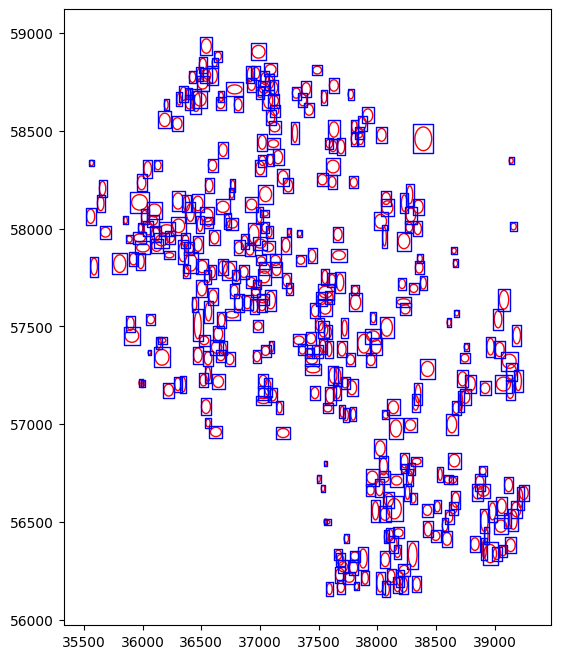

In [86]:
import matplotlib.pyplot as plt
from pprint import pp as pprint

yolo_annotations = gpd.read_file(os.path.join(SAVE_DIR, "expanded_bboxes-adaptiveMargin-slide-2024-04-03T07-52-35-R1-S2.geojson"))
pprint(yolo_annotations.iloc[0])
print("========================================^v^v^v^======================================")
pprint(annotations.iloc[0])

fig, ax = plt.subplots(figsize=(8,8))
annotations.plot(ax=ax, facecolor="none", edgecolor="red")
yolo_annotations.plot(ax=ax, facecolor="none", edgecolor="blue")
plt.show()